#**Logistic Regression to Analyze the Survival Chances in the Titanic shipwreck** 
The sinking of the Titanic is one of the most infamous shipwrecks in history. On April 15, 1912,
during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding
with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in
the death of 1502 out of 2224 passengers and crew. While there was some element of luck
involved in surviving, it seems some groups of people were more likely to survive than others. In
this analysis, we shall build a predictive model using Logistic Regression that will give insights into which sorts of
people were more likely to survive.

In [1]:
#importing the basic required libraries
import numpy as np
import pandas as pd

##Reading data from the given data format(excel file)

In [2]:
from google.colab import files 
uploaded= files.upload() #uploading the files

Saving test.xls to test.xls
Saving train.xls to train.xls


In [3]:
import io
#creating dataframes from the excel files
df=pd.read_excel(io.BytesIO(uploaded['train.xls'])) 
test_df=pd.read_excel(io.BytesIO(uploaded['test.xls']))


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##**Cleaning and Preparing the Data for Analysis**

####Creating a new variable called 'Title':

In [7]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [8]:
df['Title'] = df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace('Mlle', 'Miss')

####Creating a new variable called 'FamilySize':

In [9]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

###Filtering the data required from dataframe:
While the dataframe contains a wealth of information, we shall limit our analysis to only the required variables in the data which will be helpful for our analysis. 
The columns 'Ticket', 'Name' and 'Passenger ID' have been logically found to be irrelevant to our area of analysis and hence have been ignored.

In [10]:
required_columns=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
                  'Parch', 'Fare', 'Embarked', 'Cabin','Title','FamilySize'] #list of all columns that will be relevanat to our analysis

In [11]:
df=df[required_columns]

###Cleaning the data:

In [12]:
#removing all the trailing and leading spaces from the data values
for i in required_columns:
  for j in range(0,len(df[i])):
     df[i][j]=str(df[i][j]).strip() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
df = df.replace('nan',np.nan, regex=True) #replacing the undefined values with np.nan

In [14]:
natural_numerical_columns=['Survived', 'Pclass', 'Age', 'SibSp',
                  'Parch', 'Fare','FamilySize'] #columns that are of numerical type by nature

In [15]:
for i in natural_numerical_columns: 
  df[i]=df[i].astype('float') #converting all values in the numerical columns of df to float

###Handling the NaN values in the data:

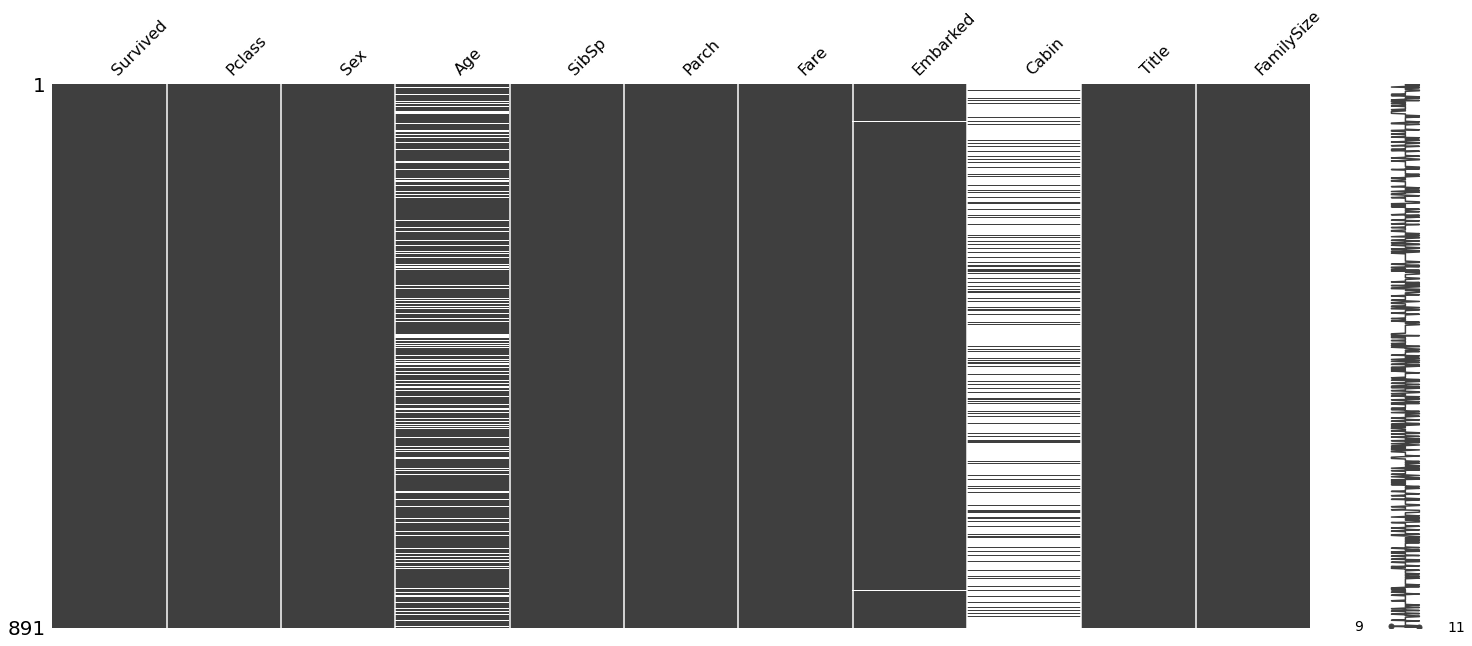

In [16]:
import missingno as msno 
msno.matrix(df) #visualizing the missing data/NaN values in the dataframe

From the above matrix, we infer that:

*   The column/variable 'Cabin' has a very high number of NaN values. Hence it is best to discard the column/variable.
*   The column/variable 'Age' also has a significant number of NaN values. But they can be handled using imputation.
* The column/variable 'Embarked' also has few missing values.



In [17]:
df = df.drop(columns='Cabin') #discarding the 'Cabin' variable as it has very high number of NaN values

In [18]:
print("variance in 'Age':",np.var(df['Age'], axis = None)) #finding the variance in the 'Age' variable

variance in 'Age': 210.7235797536662


From the above analysis, we infer that:


*   The variance of the 'Age' column/variable is high. Hence, we cannot replace the missing values in it using the mean value.


####Imputing the missing values in the columns 'Age' and 'Embarked' using the datawig's SimpleImputer(which uses some simple default encoders and featurizers that usually yield decent imputation quality):



Given a data frame, a model is trained to predict observed values in label column using values observed in other columns.

In [19]:
!pip install datawig
import datawig

# impute missing values(particularly in the columns 'Age' and 'Embarked') using datawig's SimpleImputer
df = datawig.SimpleImputer.complete(df)

     |████████████████████████████████| 61 kB 40 kB/s 
     |████████████████████████████████| 7.0 MB 10.4 MB/s 
     |████████████████████████████████| 10.4 MB 43.7 MB/s 
     |████████████████████████████████| 29.6 MB 39 kB/s 
     |████████████████████████████████| 13.8 MB 132 kB/s 
  Created wheel for datawig: filename=datawig-0.2.0-py3-none-any.whl size=72678 sha256=fcde31f07740eafe217bb18486c7e7ac3c0e07c21f38c6ed8e63a3c97c0243ce
  Stored in directory: /root/.cache/pip/wheels/23/44/aa/12cf6e868f0d71e3c4e57796330094461ade4cb3f1a3acd6c4
Successfully built datawig
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4213: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  if callable(index) or is_dict_like(index):
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4213: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  if callable(index) or is_dict_like(index):
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4213: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  if callable(index) or is_dict_like(index):
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4213: FutureWarning: 'is_extension_type' is deprecated and will be removed in a future version.  Use 'is_extension_array_dtype' instead.
  if callable(index) or is_dict_like(index):
/usr/local/lib/python3.7/dis

In [20]:
#reloading the most recent versions of libraries that have been uninstalled by the datawig imputer implementation
import os
import torch
import torchvision
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

###Encoding of the Non-Numerical Values:

In [21]:
#Mapping the non-numerical type variable 'Sex', 'Embarked' and 'Title' to numerical values
df['Sex'] = df['Sex'].map({'male':0, 'female':1})
df['Embarked'] = df['Embarked'].map({'C':0, 'Q':1, 'S':2})
df['Title'] = df['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Others':4})

##**Exploratory Data Analysis**

In [22]:
df.shape

(891, 10)

* Dataset comprises of 891 observations and 10 characteristics/variables.
* Out of which 1 ('Survived') is the dependent variable and the rest 9 are independent variables.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      891 non-null    float64
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   SibSp       891 non-null    float64
 5   Parch       891 non-null    float64
 6   Fare        891 non-null    float64
 7   Embarked    891 non-null    int64  
 8   Title       891 non-null    int64  
 9   FamilySize  891 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 69.7 KB


In [24]:
columns=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked','Title','FamilySize']

Inferances:
* All columns have only float and integer values.
* No variable column has missing values. (i.e. we have already handled all other NaN/missing values)

In [25]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.793788,0.523008,0.381594,32.204208,1.531987,1.895623,1.904602
std,0.486592,0.836071,0.477990,13.627255,1.102743,0.806057,49.693429,0.794531,0.788465,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.910400,1.000000,1.000000,1.000000
50%,0.000000,3.000000,0.000000,29.000000,0.000000,0.000000,14.454200,2.000000,2.000000,1.000000
75%,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.000000,2.000000,2.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,4.000000,11.000000


Inferances:
* There is a notable difference between 75th %tile and max values for the varibales-'Age', 'SibSp', 'Parch', 'Fare' and 'FamilySize'. This suggests that extreme values(outliers) are also present in the data.

###Visualizing the data:

In [50]:
# Importing the basic libraries required for visualizations
import os
import torch
import torchvision
import tarfile
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
!pip install pandas==1.1.5

     |████████████████████████████████| 9.5 MB 6.4 MB/s 
     |████████████████████████████████| 15.7 MB 192 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
mxnet 1.4.0 requires numpy<1.15.0,>=1.8.2, but you have numpy 1.21.2 which is incompatible.
datawig 0.2.0 requires pandas==0.25.3, but you have pandas 1.1.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.

Text(0, 0.5, 'Passenger Count')

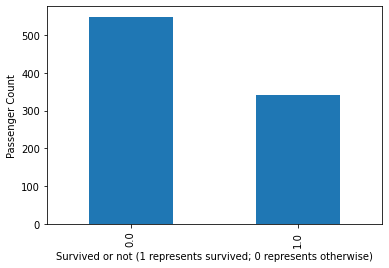

In [28]:
plt = df.Survived.value_counts().plot(kind='bar')
plt.set_xlabel('Survived or not (1 represents survived; 0 represents otherwise)')
plt.set_ylabel('Passenger Count')
 # 0 represnts did not survive the shipwreck
 # 1 represents survived the shipwreck

Inferance:
* A majority of passengers couldn't survive.
* The **Data is imbalanced.** Hence we will have to deal with probability measures rather than total net count/numbers.

In [29]:
l=np.array(columns)

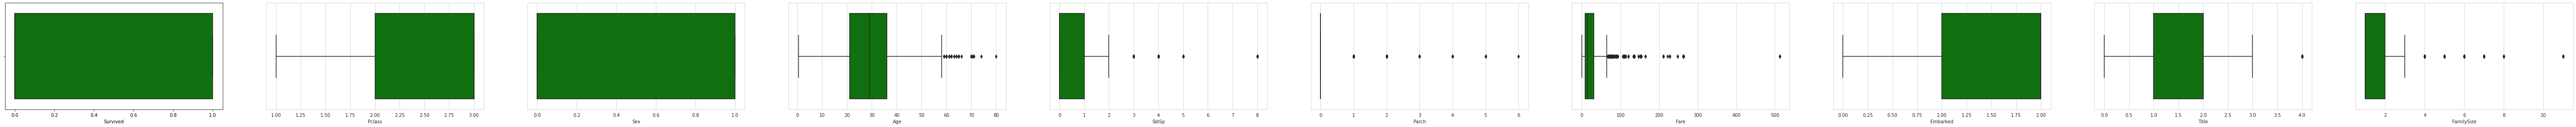

In [32]:
# Plotting a box plot to show the distribution of quantitative data in a way that facilitates comparisons between variables 
number_of_columns=10
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(100,50))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(x=df[l[i]],y=None,color='green')

The above box plot shows the distribution of quantitative data in a way that facilitates comparisons between the variables. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution. A segment inside the rectangle shows the median and “whiskers” above and below the box show the locations of the minimum and maximum.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

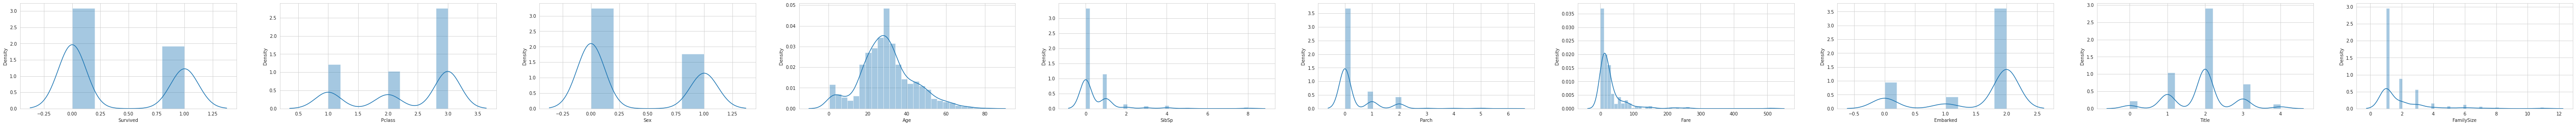

In [33]:
#Using Kernel density estimate (kde) for plotting the shape of distributions to check the linearity of variables and look for skewness of features
plt.figure(figsize=(100,50))
l=np.array(columns)
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True) 

Inferances:
* The number of people who did not survive the shipwreck is much greater than those who did survive.
* Most people on the ship had a 3rd class ticket followed by 1st class, with 2nd class tickets being the least in number.
* The number of men onboard were considerably higher than the women boarded.
* Most people who onboarded the ship were of age group in the range 20-40 years old.
* A predominate number of onboarders did not have any siblings/parents/children aboard the Titanic.
* Most of the onboarders had the name title "Mr".
* Southampton was the port where most onboarders embarked, followed by Cherbourg and then Queenstown.


In [34]:
df['Survived'].value_counts() *100/len(df)

0.0    61.616162
1.0    38.383838
Name: Survived, dtype: float64

Inferance: 
* **The calculation shows that only about 38% of the passengers survived. Not the best odds.**

Text(0, 0.5, 'Survival Probability')

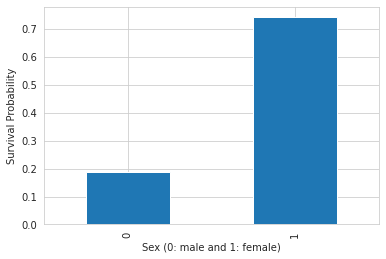

In [35]:
plt = df[['Sex', 'Survived']].groupby('Sex').mean().Survived.plot(kind='bar')
plt.set_xlabel('Sex (0: male and 1: female)')
plt.set_ylabel('Survival Probability') #0 represents male and 1 represents female

In [36]:
n_m=df[df['Sex']==0].Sex.count() #number of male onboarders

df_male=df[df['Sex']==0]
n_m_s=len(df_male[df_male['Survived']==1]) #number of male who survived

percentage_male_survived=(n_m_s/n_m)*100
percentage_male_survived

18.890814558058924

In [37]:
n_f=df[df['Sex']==1].Sex.count() #number of female onboarders

df_female=df[df['Sex']==1]
n_f_s=len(df_female[df_female['Survived']==1]) #number of female who survived

percentage_female_survived=(n_f_s/n_f)*100
percentage_female_survived

74.20382165605095

Inferance: 

* **Women have a survival rate of 74%, while men have a survival rate of about 19%.** The survival rate for the female passengers is very high because the strict maritime tradition of evacuating women and children first in such situations of danger.

Text(0, 0.5, 'Survival Probability')

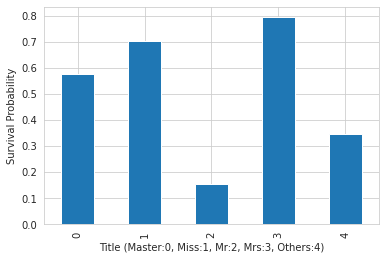

In [38]:
plt = df[['Title', 'Survived']].groupby('Title').mean().Survived.plot(kind='bar')
plt.set_xlabel('Title (Master:0, Miss:1, Mr:2, Mrs:3, Others:4)')
plt.set_ylabel('Survival Probability')
#'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Others':4

Inferance: 
* **The survival probability for 'Mrs' and 'Miss' is high compared to the other classes.**

Text(0, 0.5, 'Survival Probability')

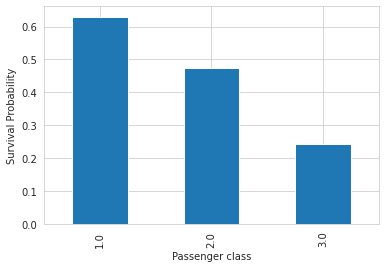

In [39]:
plt = df[['Pclass', 'Survived']].groupby('Pclass').mean().Survived.plot(kind='bar')
plt.set_xlabel('Passenger class')
plt.set_ylabel('Survival Probability')

Inferance:
* **The first class has the highest probability of survival followed by the second and third class.**

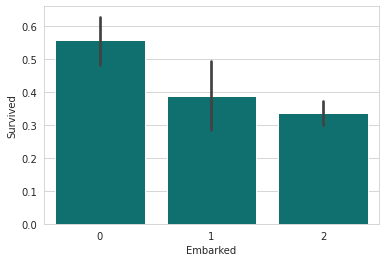

In [40]:
sns.barplot(x='Embarked', y='Survived', data=df, color="teal")

Inferance:
* **The number of people who survived varies with the port of embarkation as: Cherbourg>Queenstown>Southampton.** Passengers who boarded in Cherbourg, France, appear to have the highest survival rate. Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown. This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck).
It's also worth noting the size of the whiskers in these plots. Because the number of passengers who boarded at Southhampton was highest, the confidence around the survival rate is the highest. The whisker of the Queenstown plot includes the Southhampton average, as well as the lower bound of its whisker. It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southhampton counterparts.

Text(0, 0.5, 'Survival Probability')

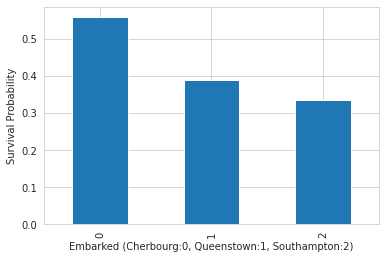

In [41]:
plt = df[['Embarked', 'Survived']].groupby('Embarked').mean().Survived.plot(kind='bar')

plt.set_xlabel('Embarked (Cherbourg:0, Queenstown:1, Southampton:2)')
plt.set_ylabel('Survival Probability') #'Cherbourg':0, 'Queenstown':1, 'Southampton':2 

Inferance:
* **The Survival Probability varies with the port of embarkation as: Cherbourg>Queenstown>Southampton.**

Text(0, 0.5, 'Survival Probability')

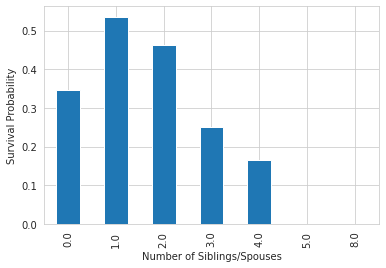

In [42]:
plt= df[['SibSp', 'Survived']].groupby('SibSp').mean().Survived.plot(kind='bar')
plt.set_xlabel('Number of Siblings/Spouses')
plt.set_ylabel('Survival Probability')

Text(0, 0.5, 'Survival Probability')

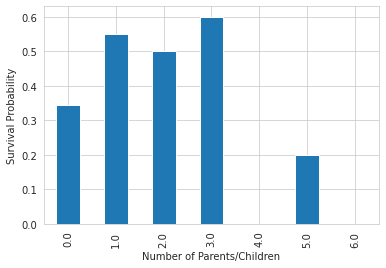

In [43]:
plt = df[['Parch', 'Survived']].groupby('Parch').mean().Survived.plot(kind='bar')
plt.set_xlabel('Number of Parents/Children')
plt.set_ylabel('Survival Probability')

Text(0, 0.5, 'Survival Probability')

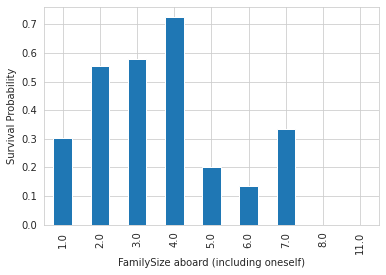

In [44]:
plt = df[['FamilySize', 'Survived']].groupby('FamilySize').mean().Survived.plot(kind='bar')
plt.set_xlabel('FamilySize aboard (including oneself)')
plt.set_ylabel('Survival Probability') 

General Inferance:
* **Individuals traveling without family were more likely to die in the disaster than those with family aboard.** Given the era, it's likely that individuals traveling alone were male.

Text(0, 0.5, 'Survival Probability')

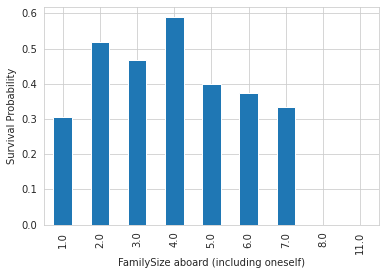

In [45]:
df_children=df[df.Age>20]
df_children=df_children[['FamilySize', 'Survived']]
plt = df_children.groupby('FamilySize').mean().Survived.plot(kind='bar')
plt.set_xlabel('FamilySize aboard (including oneself)')
plt.set_ylabel('Survival Probability') 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


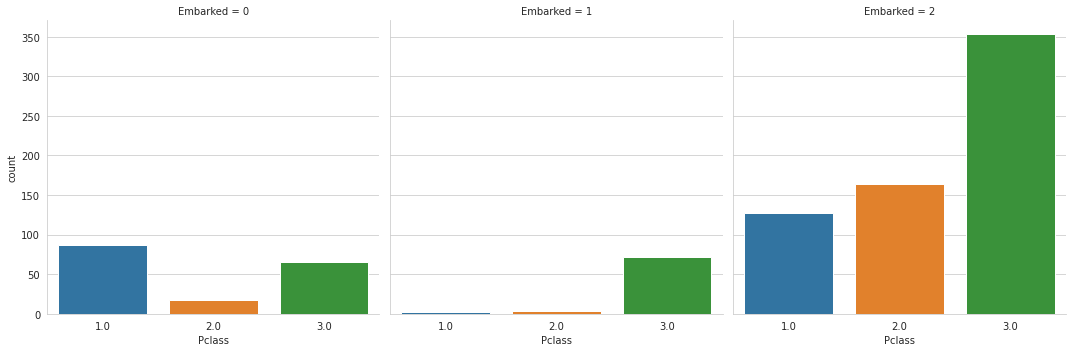

In [46]:
sns.factorplot('Pclass', col = 'Embarked', data = df, kind = 'count')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


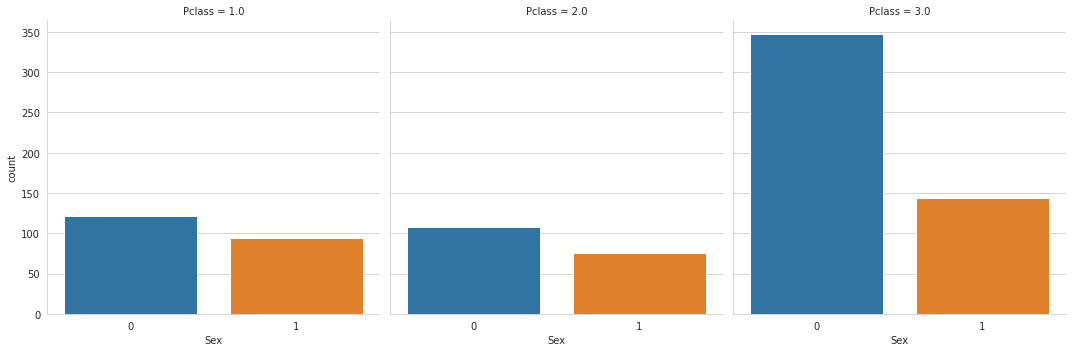

In [47]:
sns.factorplot('Sex', col = 'Pclass', data = df, kind = 'count')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


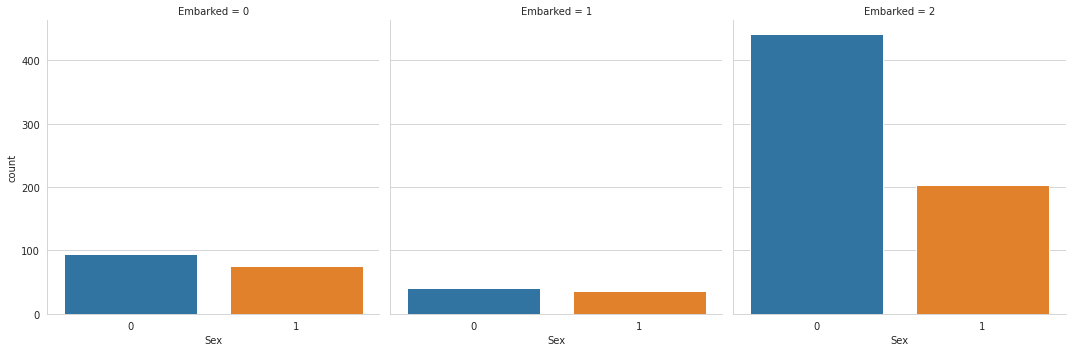

In [48]:
sns.factorplot('Sex', col = 'Embarked', data = df, kind = 'count')

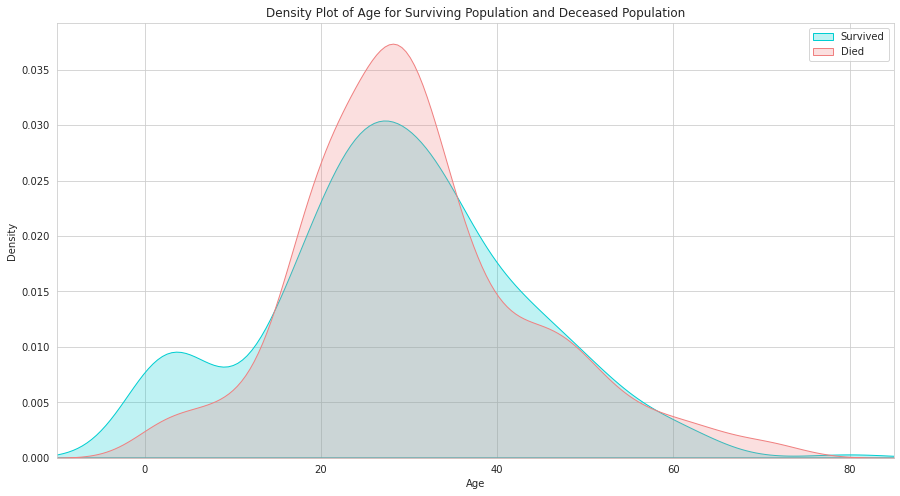

In [51]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["Age"][df.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["Age"][df.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Key Inferance:
* **The age distribution for survivors and deceased is actually very similar. One notable difference is that, of the survivors, a larger proportion were children.** The passengers evidently made an attempt to save children by giving them a place on the life rafts.

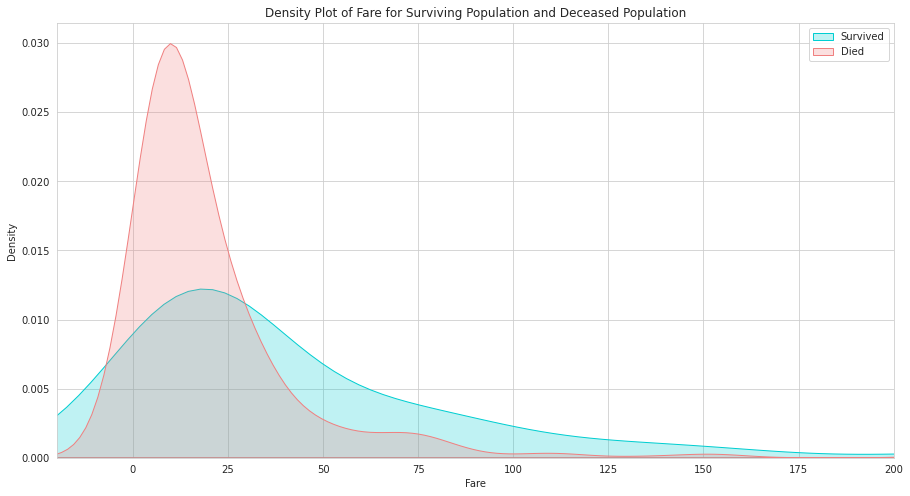

In [52]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["Fare"][df.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["Fare"][df.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

Key Inferance:
* **A notable inferance is that, those who's tickets costed less/payed less fare had a lesser survival rate.** This evidently has to do with the fact that the seats which costed more were well-positioned and made it easier to escape the shipwreck from.

###**To use logistic regression for modelling, it is necessary to remove correlated variables to improve our model.**

In [53]:
#Finding correlations in the data using the pandas “.corr()” function
corr_matrix = df.corr()
corr_matrix

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
Survived,1.000000,-0.338481,0.543351,-0.067878,-0.035322,0.081629,0.257307,-0.174199,-0.071174,0.016639
Pclass,-0.338481,1.000000,-0.131900,-0.403594,0.083081,0.018443,-0.549500,0.170334,-0.181177,0.065997
Sex,0.543351,-0.131900,1.000000,-0.110584,0.114631,0.245489,0.182333,-0.115513,-0.060299,0.200988
Age,-0.067878,-0.403594,-0.110584,1.000000,-0.309245,-0.213539,0.096724,-0.025234,0.525846,-0.318039
SibSp,-0.035322,0.083081,0.114631,-0.309245,1.000000,0.414838,0.159651,0.070653,-0.209813,0.890712
Parch,0.081629,0.018443,0.245489,-0.213539,0.414838,1.000000,0.216225,0.042325,-0.117587,0.783111
Fare,0.257307,-0.549500,0.182333,0.096724,0.159651,0.216225,1.000000,-0.229304,-0.013273,0.217138
Embarked,-0.174199,0.170334,-0.115513,-0.025234,0.070653,0.042325,-0.229304,1.000000,0.004439,0.069434
Title,-0.071174,-0.181177,-0.060299,0.525846,-0.209813,-0.117587,-0.013273,0.004439,1.000000,-0.202145
FamilySize,0.016639,0.065997,0.200988,-0.318039,0.890712,0.783111,0.217138,0.069434,-0.202145,1.000000


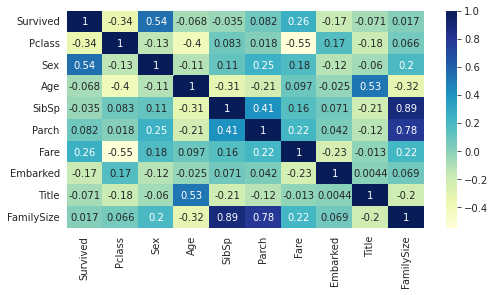

In [54]:
#Visualizing the correlation matrix using a heatmap in seaborn
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, cmap='YlGnBu',annot=True)

Inferance:
* **The variables 'FamilySize', 'Parch' and 'SibSp' were found to have a significantly high correlation.**

The above will be used to remove correlated variables during the feature selection decision for the model to avoid redundancy.

In [55]:
df = df.drop(columns=['SibSp','Parch']) #dropping the redundant columns from the dataframe

##**Preprocessing the test data**:
We preprocess the test data using the same methods/techniques used for the training data.

In [56]:
test_inputs=test_df

In [57]:
test_df.isnull().sum() #finding the number of null values in the given test dataframe

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [58]:
test_df = test_df.drop(columns=['Ticket', 'PassengerId', 'Cabin']) #dropping the redundant columns from the test dataframe

In [59]:
#mapping the categorical 'Sex' and 'Embarked' variables to numerical values
test_df['Sex'] = test_df['Sex'].map({'male':0, 'female':1})
test_df['Embarked'] = test_df['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [60]:
#creating a new variable 'Title' from the 'Name' variable
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df = test_df.drop(columns='Name')

test_df['Title'] = test_df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')
test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')

test_df['Title'] = test_df['Title'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Others':4}) #mapping the categorical 'Title' variable to numerical values

In [61]:
#Create a new variable 'FamilySize' from the 'SibSp' and 'Parch' variables
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

In [62]:
test_df = test_df.drop(columns=['SibSp','Parch']) #dropping the redundant columns from the dataframe

In [63]:
#imputing missing values in the test data using datawig's SimpleImputer
test_df = datawig.SimpleImputer.complete(test_df)

In [64]:
#reloading the most recent versions of libraries that have been uninstalled by the datawig imputer
import os
import torch
import torchvision
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

####Splitting 'Train data' into 'Training data' and 'Validation data':

In [65]:
#import logistic regression
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score #for accuracy_score
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
#import xgboost for test purpose (Not Required)
from xgboost import XGBClassifier
import numpy as np

In [66]:
train_df=df

In [67]:
from sklearn.utils import shuffle
train_df = shuffle(train_df)

In [68]:
training_data, valid_data = train_test_split(train_df, test_size=0.2)

In [69]:
X_train = training_data.drop(columns='Survived')
y_train = training_data.Survived
y_train = pd.DataFrame({'Survived':y_train.values})

In [70]:
X_valid = valid_data.drop(columns='Survived')
y_valid = valid_data.Survived

In [71]:
X_test=test_df

In [72]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

X_valid.to_csv('X_valid.csv', index=False)
y_valid.to_csv('y_valid.csv', index=False)

X_test.to_csv('X_test.csv', index=False)

##**Building the Logistic Regression Model**

In [73]:
# Initialize our algorithm
logmodel = LogisticRegression()

In [74]:
logmodel.fit(X_train,y_train) #fitting the training data to our logistic regression model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##**Visualizations and Conclusions:**

In [75]:
print("Score of the logistic regression model on the validation dataset:", logmodel.score(X_valid,y_valid))

y_valid_predictions = logmodel.predict(X_valid)

Score of the logistic regression model on the validation dataset: 0.8212290502793296


**Score of the logistic regression model on the validation dataset: 0.7653631284916201**


####**Confusion Matrix:**
A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test/validation data for which the true values are known. It allows the visualization of the performance of an algorithm.

Text(0.5, 1.0, 'Confusion Matrix')

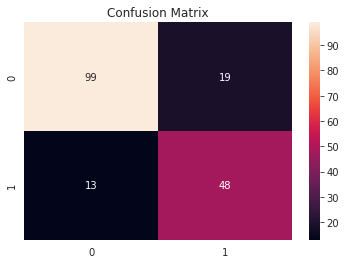

In [76]:
cm = confusion_matrix(y_valid,y_valid_predictions)

#visualize the confusion matrix 
sns.heatmap(confusion_matrix(y_valid,y_valid_predictions),annot=True)
plt.title('Confusion Matrix')

In [77]:
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Logistic Regression is',round(accuracy_score(y_valid_predictions,y_valid)*100,2))

--------------The Accuracy of the model----------------------------
The accuracy of the Logistic Regression is 82.12


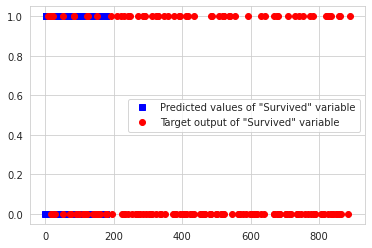

In [78]:
plt.plot(y_valid_predictions,'sb')
plt.plot(y_valid, 'or')
plt.legend(['Predicted values of "Survived" variable', 'Target output of "Survived" variable']);
plt.show()

###**Making predictions for the test data using the built model:**

In [79]:
predictions = logmodel.predict(X_test)
y_test=predictions

In [80]:
output=test_inputs
output["Survived"]=y_test

In [81]:
output.to_csv('output.csv', index=False) #saving the predicted output